In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")

from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

from tqdm.notebook import tqdm

import random
import pickle

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

%load_ext autoreload
%autoreload 2

from saccade_config import *

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line

from analysis_helpers import load_data, load_data_by_session_id, savefig, heatmap_log_proba_plot, load_additional_data
from eye_plotting import STIM_ABBREV, STIM_COLORS, STIM_ORDERING

In [2]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
CRE_PLOT_KEY = "cre_abbrev"
print(f"There are {len(cells):,} total cells.")
cells["session_indices"] = cells["session_indices"].apply(eval)
cells.head()

There are 32,504 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_total,n_left,n_right,mean_left_response,mean_right_response,median_left_response,median_right_response,direction_selectivity,frac_left_significant,frac_right_significant,wilcoxon_signed_rank_p,ranksum_p_by_direction
specimen_id,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 11), (510345479, 67), (510514474,...",0,0.161850,70,25,37,-0.005011,0.026047,-0.003895,-0.006539,1.476375,0.20,0.135135,0.315548,0.311696
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 109), (510345479, 68), (510514474...",0,0.879275,70,25,37,-0.008454,-0.004121,-0.013324,-0.007777,-0.344511,0.20,0.162162,0.506548,0.570835
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 27), (510345479, 205), (510514474...",0,0.995625,70,25,37,-0.084782,-0.058854,-0.033635,0.006277,-0.180513,0.20,0.270270,0.209372,0.016882
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 6), (510345479, 206), (510514474,...",0,0.019375,70,25,37,0.133313,0.288431,-0.005347,0.007910,0.367802,0.24,0.189189,0.455575,0.682560
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 9), (510345479, 22), (510514474, 9))",0,0.273825,70,25,37,-0.013324,0.012467,-0.006405,0.009456,-30.087633,0.24,0.216216,0.776540,0.023814


In [4]:
# eval(cells.at[589170196, "session_indices"])

cell_to_sessions = {}
sessions_set = set()

for specimen_id in cells.index:
    session_indices = cells.at[specimen_id, "session_indices"]
    sessions = [session_id for session_id, cell_index in session_indices]
    cell_to_sessions[specimen_id] = sessions
    sessions_set.update(sessions)

print(f"There are {len(cell_to_sessions):,} cells across {len(sessions_set)} unique pairings of sessions.")

There are 32,504 cells across 736 unique pairings of sessions.


# Load cell responses to saccades

In [5]:
save_file = r"/Users/chase/Desktop/saccade_responses_by_stim.pickle"
should_load_from_file = True

if should_load_from_file:
    with open(save_file, "rb") as file:
        cell_responses = pickle.load(file)
else:
    slice_after = slice(0, 10)
    slice_before = slice(-45, -15)
    cell_responses = []

    session_cache = {}

    for specimen_id in tqdm(cells.index[cells["response_classification"] != 0]):
        session_indices = cells.at[specimen_id, "session_indices"]
        response_classification = cells.at[specimen_id, "response_classification"]
        is_ds = cells.at[specimen_id, "ranksum_p_by_direction"] < 0.05
        pref_dir = np.sign(cells.at[specimen_id, "direction_selectivity"])
        session_responses = []
        allowed_sacc_dir = None

        if response_classification == 1 and is_ds:
            allowed_sacc_dir = "R" if pref_dir == 1 else "L"

        for session_id, cell_index in session_indices:
            if session_id in session_cache:
                data = session_cache[session_id]
            else:
                full_data = load_data_by_session_id(session_id)
                eye_tracking = full_data["eye_tracking"]
                stim_epoch = full_data["stim_epoch"]
                data = {
                    "dff_traces": full_data["dff_traces"],
                    "saccades": []
                }
                for ss, se in full_data["saccades"]:
                    mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
                    stim = get_stim_at_frame(stim_epoch, ss)
                    data["saccades"].append((ss, se, dir, stim))
                session_cache[session_id] = data
            
            dff = data["dff_traces"]
            responses = {}

            for ss, se, dir, stim in data["saccades"]:
                if allowed_sacc_dir is not None and dir != allowed_sacc_dir:
                    continue
                
                if stim not in responses:
                    responses[stim] = []
                
                response = dff[cell_index, (ss+slice_after.start):(ss+slice_after.stop)].mean() - dff[cell_index, (ss+slice_before.start):(ss+slice_before.stop)].mean()
                responses[stim].append(response)
            
            session_responses.append(responses)

        n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in session_responses]

        cell_responses.append({
            "specimen_id": specimen_id,
            "response_classification": response_classification,
            "allowed_sacc_dir": allowed_sacc_dir,
            "session_responses": session_responses,
            "n_spontaneous_responses": n_spontaneous_responses,
            CRE_PLOT_KEY: cells.at[specimen_id, CRE_PLOT_KEY],
            "targeted_structure": cells.at[specimen_id, "targeted_structure"],
        })

    del session_cache # Free up memory

    with open(save_file, "wb") as file:
        pickle.dump(cell_responses, file, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/3068 [00:00<?, ?it/s]

T = 0: 3068 cells
T = 1: 2967 cells
T = 2: 2762 cells
T = 3: 2623 cells
T = 4: 2534 cells
T = 5: 2409 cells
T = 6: 2284 cells
T = 7: 2216 cells
T = 8: 2136 cells
T = 9: 2052 cells
T = 10: 1908 cells
T = 11: 1841 cells
T = 12: 1754 cells
T = 13: 1642 cells
T = 14: 1555 cells
T = 15: 1520 cells
T = 16: 1423 cells
T = 17: 1371 cells
T = 18: 1312 cells
T = 19: 1245 cells
T = 20: 1179 cells
T = 21: 1159 cells
T = 22: 1128 cells
T = 23: 1079 cells
T = 24: 1037 cells
T = 25: 997 cells


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


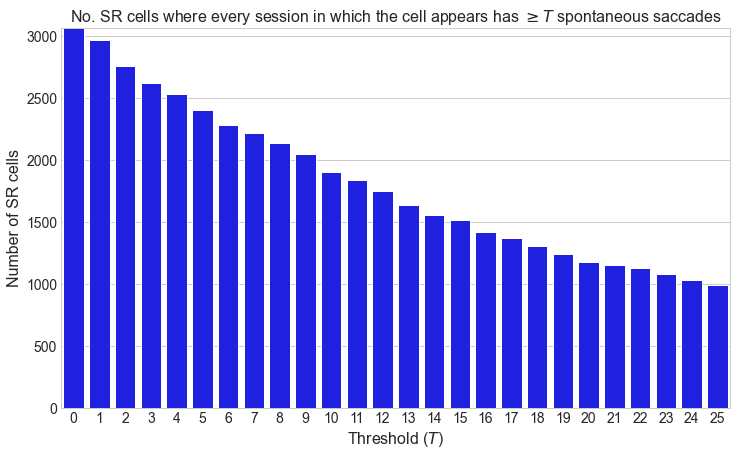

In [6]:
x = list(range(0, 26))
y = []

for thresh in x:
    n = 0
    for r in cell_responses:
        n_spont = [len(s["spontaneous"]) if "spontaneous" in s else 0 for s in r["session_responses"]]
        if min(n_spont) >= thresh:
        # if sum(n_spont) >= thresh:
            n += 1
    y.append(n)
    print(f"T = {thresh}: {n} cells")
    # y.append(n / len(cell_responses)

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(x, y, color="blue", ax=ax)
    ax.set_title("No. SR cells where every session in which the cell appears has $\geq T$ spontaneous saccades", fontsize=16)
    ax.set_xlabel("Threshold ($T$)", fontsize=16)
    ax.set_ylabel("Number of SR cells", fontsize=16)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
    ax.set_ylim(0, y[0])

In [7]:
# if n_spontaneous_responses > threshold
# normalized_responses = {}

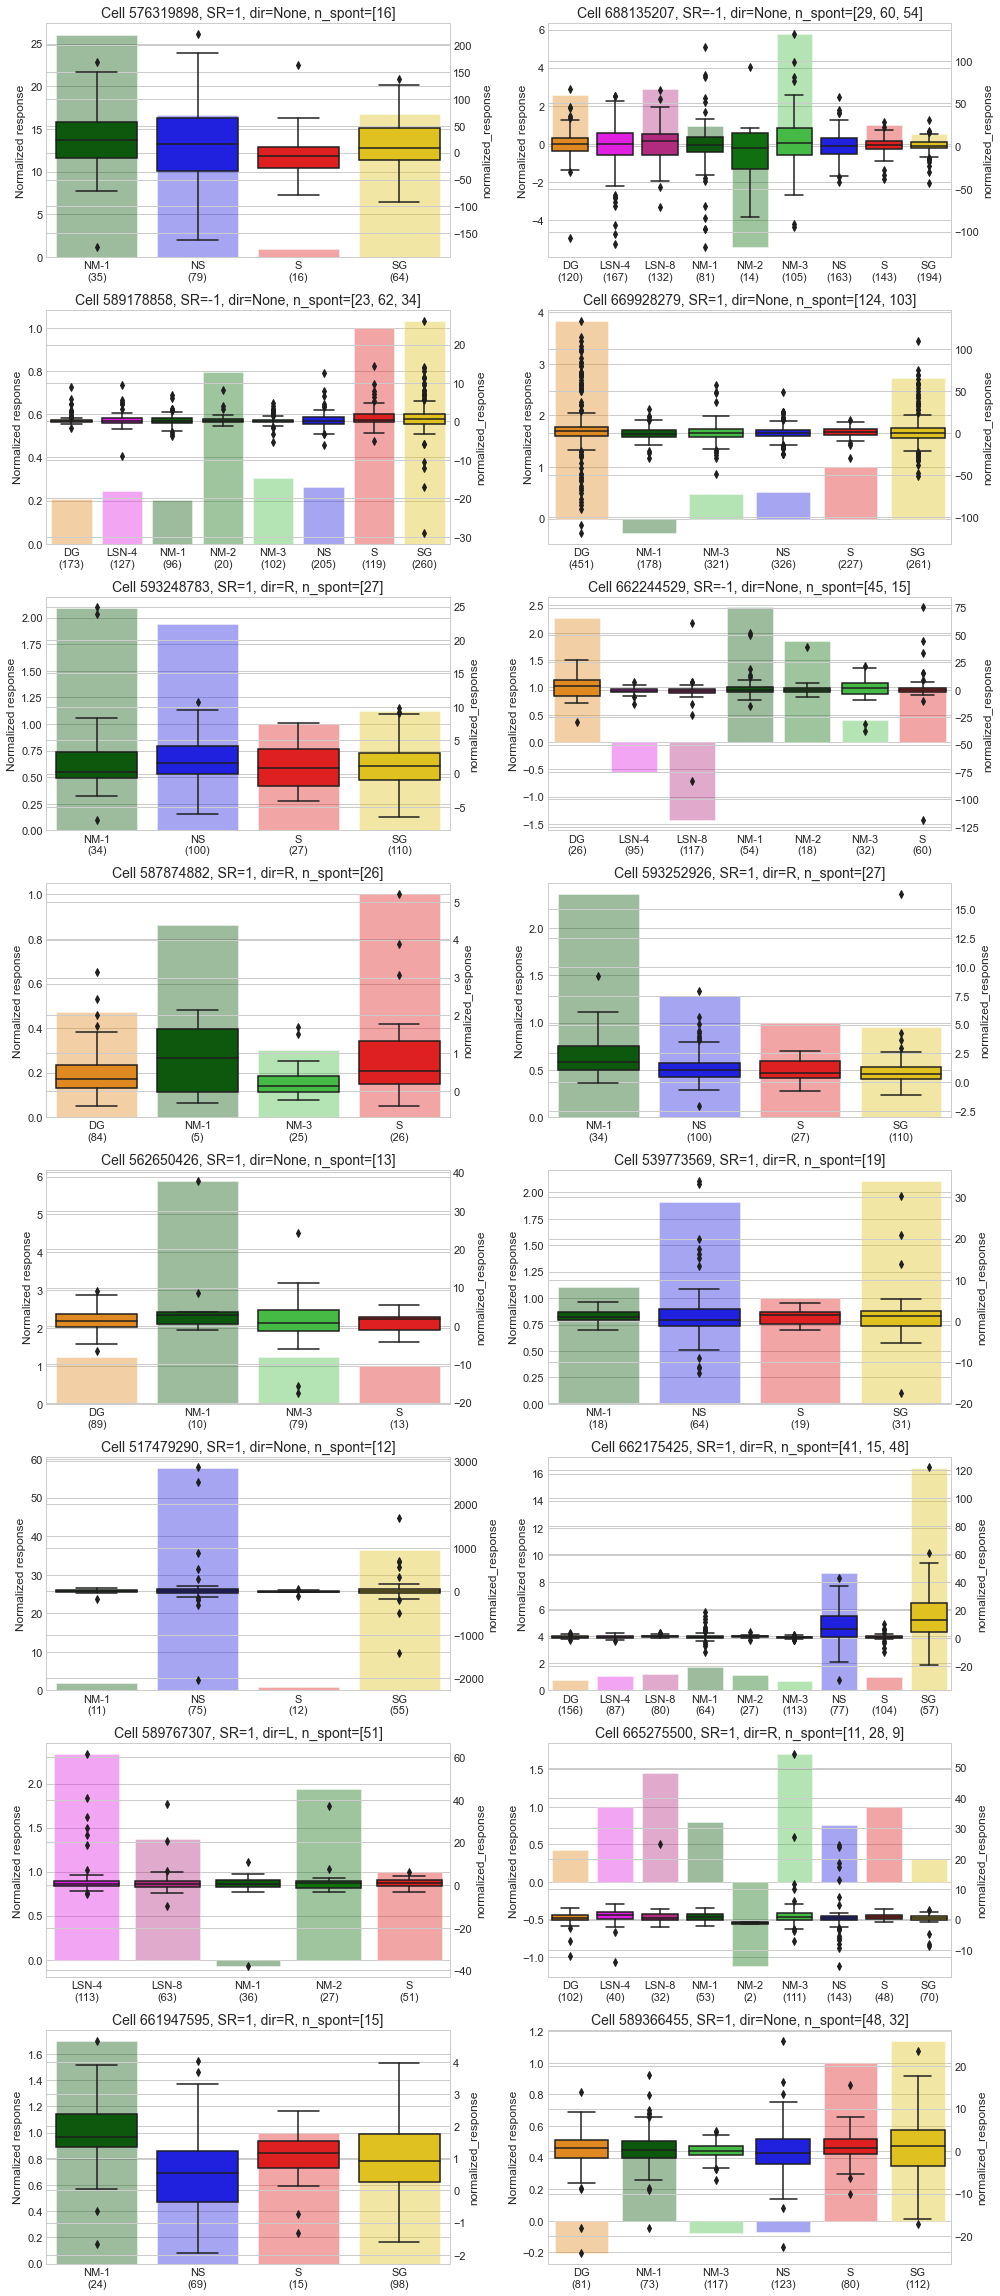

In [8]:
spont_thresh = 8

with plt.style.context("seaborn-whitegrid"):
    n_cells = 8
    fig, axs = plt.subplots(figsize=(14, 32), nrows=n_cells, ncols=2)
    proba_title = "KS on norm response"

    for ax_responses, ax_probas in np.row_stack([axs, np.column_stack([axs[:, 1], axs[:, 0]])]):
        r = None
        while True:
            r = random.choice(cell_responses)
            n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
            if min(n_spontaneous_responses) >= spont_thresh:
                break

        plt_data = []
        
        for session_response_data in r["session_responses"]:
            normalization_constant = np.mean(session_response_data["spontaneous"])

            for stim, responses in session_response_data.items():
                # if stim not in normalized_responses: normalized_responses[stim] = []
                for response in responses:
                    # normalized_responses[stim].append(response / normalization_constant)
                    plt_data.append(dict(stim=STIM_ABBREV[stim], normalized_response=(response/normalization_constant)))
        
        df = pd.DataFrame(plt_data)
        df_mean = df.groupby("stim").mean().reset_index()
        stim_order = df_mean["stim"].unique()
        sns.barplot(data=df_mean, x="stim", y="normalized_response", ax=ax_responses, palette=STIM_COLORS, alpha=0.4, order=stim_order)
        sns.boxplot(data=df, x="stim", y="normalized_response", ax=ax_responses.twinx(), palette=STIM_COLORS, order=stim_order)
        ax_responses.set_xticklabels([f"{stim}\n({(df['stim'] == stim).sum()})" for stim in stim_order])
        # ax_responses.axhline(1, color="black", linestyle="dashed", linewidth=1)
        
        ax_responses.set_title(f"Cell {r['specimen_id']}, SR={r['response_classification']}, dir={r['allowed_sacc_dir']}, n_spont={r['n_spontaneous_responses']}", fontsize=14)
        ax_responses.set_xlabel("")
        ax_responses.set_ylabel("Normalized response")

        stims = df["stim"].unique()
        p_matrix = np.zeros((len(stims), len(stims)))
        for i in range(len(stims)):
            p_matrix[i,i] = np.nan
            for j in range(i+1, len(stims)):
                p = stats.ks_2samp(df["normalized_response"][df["stim"] == stims[i]], df["normalized_response"][df["stim"] == stims[j]])[1]
                p_matrix[i,j] = p_matrix[j,i] = p

        # heatmap_log_proba_plot(p_matrix, ticklabels=stims, title=proba_title, cbar_label="p", ax=ax_probas)
        proba_title = None # Only show the title on the topmost plot
    
    fig.tight_layout()


In [9]:
# fig.savefig("/Users/chase/Desktop/bystim.png")

In [10]:
SPONT_THRESH = 8
STIM_THRESH = 0

Using test: Wilcoxon paired
LSN-4 (n = 1506) p = 0.5121
LSN-8 (n = 1354) p = 0.6001
SG (n = 1543) p = 0.1261
DG (n = 1476) p = 0.0249
NM-1 (n = 4463) p = 0.0003
NM-2 (n = 1463) p = 0.0109
NM-3 (n = 1476) p = 0.0000
NS (n = 1543) p = 0.0004


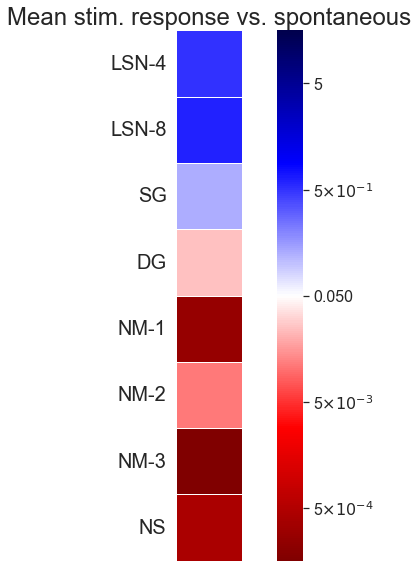

In [14]:
stims = STIM_ORDERING[1:] # Ignore "S"
p_matrix = np.zeros((len(stims), 1))

test_fn, test_name = stats.wilcoxon, "Wilcoxon paired"
# test_fn, test_name = stats.ttest_rel, "T-test paired"
print(f"Using test: {test_name}")

for i, stim in enumerate(stims):
    spont_resp, stim_resp = [], []

    for r in cell_responses:
        # Ignore cells that don't have enough responses
        # n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
        # if min(n_spontaneous_responses) < SPONT_THRESH:
        #     continue

        # if r["response_classification"] != 1:
        #     continue

        for data in r["session_responses"]:
            for stim_full, responses in data.items():
                if STIM_ABBREV[stim_full] == stim:
                    if "spontaneous" in data and len(data["spontaneous"]) >= SPONT_THRESH and len(responses) >= STIM_THRESH:
                        spont_resp.append(np.mean(data["spontaneous"]))
                        stim_resp.append(np.mean(responses))
                        break

    p = test_fn(stim_resp, spont_resp)[1]
    p_matrix[i, 0] = p
    print(f"{stims[i]} (n = {len(stim_resp)}) p = {p:.4f}")
    
fig, ax = heatmap_log_proba_plot(p_matrix, yticklabels=stims, xticklabels=[], title="Mean stim. response vs. spontaneous", titlefontsize=24, ticklabelfontsize=20) # cbar_label=f"p ({test_name})"
fig.tight_layout()
savefig(fig, "mean_stim_response_vs_spontaneous.png")

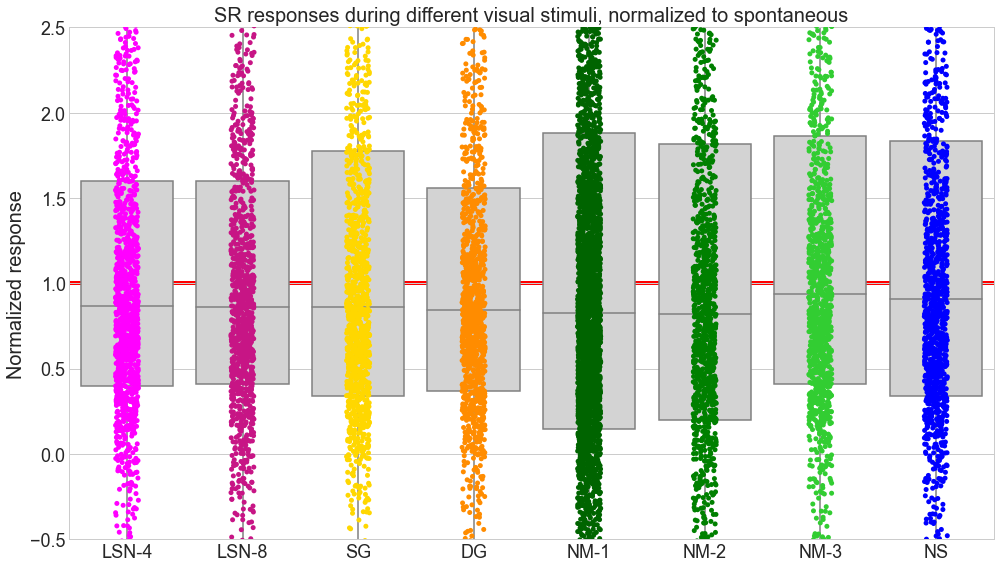

In [15]:
NORM_STIM = "spontaneous" # Stimulus to normalize the responses to

with plt.style.context("seaborn-whitegrid"):
    df = []
    df_all = []

    for r in cell_responses:
        for session_response_data in r["session_responses"]:
            for stim, responses in session_response_data.items():
                # if stim not in normalized_responses: normalized_responses[stim] = []
                mean_response = np.mean(responses)

                df_all.append({
                    CRE_PLOT_KEY: r[CRE_PLOT_KEY],
                    "stim": STIM_ABBREV[stim],
                    "targeted_structure":  r["targeted_structure"],
                    "mean_response": mean_response
                })

    for r in cell_responses:
        # Ignore cells that don't have enough responses
        # n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
        # if min(n_spontaneous_responses) < SPONT_THRESH:
        #     continue
    
        # if r["response_classification"] != 1:
        #     continue

        for session_response_data in r["session_responses"]:
            if NORM_STIM in session_response_data and len(session_response_data[NORM_STIM]) >= SPONT_THRESH:
                normalization_constant = np.mean(session_response_data[NORM_STIM])

                for stim, responses in session_response_data.items():
                    # if stim not in normalized_responses: normalized_responses[stim] = []
                    mean_response = np.mean(responses)

                    df.append({
                        "stim": STIM_ABBREV[stim],
                        "response": mean_response,
                        "normalized_response": mean_response / normalization_constant,
                        CRE_PLOT_KEY: r[CRE_PLOT_KEY],
                        "targeted_structure":  r["targeted_structure"],
                    })

    df = pd.DataFrame(df)
    df_all = pd.DataFrame(df_all)


    # Create heatmap of probabilities comparing distributions of saccade responses during each stimulus vs. spontaneous
    # stims = STIM_ORDERING[1:] # Ignore "S"
    # p_matrix = np.zeros((len(stims), 1))
    # spont_responses = df_all["mean_response"][df_all["stim"] == "S"]
    # for i in range(len(stims)):
    #     stim_responses = df_all["mean_response"][df_all["stim"] == stims[i]]
    #     p = stats.ks_2samp(stim_responses, spont_responses)[1]
    #     # p = stats.ranksums(stim_responses, spont_responses)[1]
    #     p_matrix[i, 0] = p
    #     print(stims[i], len(stim_responses), p)
    # fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=stims, title="Different stim vs. spontaneous (KS)", cbar_label="p")
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/all_stim_vs_spont.png")



    # Unnormalized responses
    # fig, ax = plt.subplots(figsize=(18, 8))
    # sns.stripplot(data=df_all, x="stim", y="mean_response", ax=ax, palette=STIM_COLORS, order=STIM_ORDERING)
    # sns.boxplot(data=df_all, x="stim", y="mean_response", ax=ax, color="lightgray", order=STIM_ORDERING)
    # plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    # ax.set_title(f"All cell responses", fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("UNNORMALIZED response", fontsize=16)
    # ax.set_ylim(0, 0.1)
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/all_unnormalized_responses_by_stim.png")


    # Normalized responses
    fig, ax = plt.subplots(figsize=(14, 8))
    order = [s for s in STIM_ORDERING if s != STIM_ABBREV[NORM_STIM]]
    sns.stripplot(data=df, x="stim", y="normalized_response", ax=ax, palette=STIM_COLORS, order=order)
    sns.boxplot(data=df, x="stim", y="normalized_response", ax=ax, color="lightgray", order=order, showmeans=False, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=18)
    ax.set_title("SR responses during different visual stimuli, normalized to spontaneous", fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("Normalized response", fontsize=20)
    ax.set_ylim(-0.5, 2.5)
    ax.axhline(1, color="red", linestyle="solid", linewidth=4, zorder=0)
    fig.tight_layout()
    savefig(fig, "normalized_responses_by_stim.png")

    # stims = order
    # p_matrix = np.zeros((len(stims), len(stims)))
    # for i in range(len(stims)):
    #     p_matrix[i,i] = np.nan
    #     for j in range(i+1, len(stims)):
    #         p = stats.ks_2samp(df["normalized_response"][df["stim"] == stims[i]], df["normalized_response"][df["stim"] == stims[j]])[1]
    #         p_matrix[i,j] = p_matrix[j,i] = p
    # fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=stims, title="All responses by stim probabilities (KS)", cbar_label="p")
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/all_responses_by_stim_probas.png")


    # df_nm1 = df[df["stim"] == "NM-1"]

    # fig, ax = plt.subplots(figsize=(18, 8))
    # sns.boxplot(data=df_nm1, x=CRE_PLOT_KEY, y="normalized_response", ax=ax, palette=CRE_COLORS, order=CRE_ORDERING)
    # plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    # ax.set_title("NM-1 cell responses by transgenic line", fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Normalized response", fontsize=16)
    # ax.set_ylim(-12, 12)
    # ax.axhline(1, color="red", linestyle="solid", linewidth=1.5)
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_cre.png")

    # lines = CRE_ORDERING # df_nm1[CRE_PLOT_KEY].unique()
    # p_matrix = np.zeros((len(lines), len(lines)))
    # for i in range(len(lines)):
    #     p_matrix[i,i] = np.nan
    #     for j in range(i+1, len(lines)):
    #         p = stats.ks_2samp(df_nm1["normalized_response"][df_nm1[CRE_PLOT_KEY] == lines[i]], df_nm1["normalized_response"][df_nm1[CRE_PLOT_KEY] == lines[j]])[1]
    #         p_matrix[i,j] = p_matrix[j,i] = p
    # fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=lines, title="NM1 responses by cre probabilities (KS)", cbar_label="p")
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_cre_probas.png")

    # fig, ax = plt.subplots(figsize=(18, 8))
    # sns.boxplot(data=df_nm1, x="targeted_structure", y="normalized_response", ax=ax)
    # plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    # ax.set_title(f"NM-1 cell responses by area", fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Normalized response", fontsize=16)
    # ax.set_ylim(-15, 15)
    # ax.axhline(1, color="gray", linestyle="solid", linewidth=1.5)
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_area.png")


LSN-4 median = 0.79, mean = 0.83
LSN-8 median = 0.79, mean = 0.84
SG median = 0.76, mean = 0.84
DG median = 0.81, mean = 0.85
NM-1 median = 0.86, mean = 0.92
NM-1 median = 0.86, mean = 0.92
NM-2 median = 0.78, mean = 0.83
NM-3 median = 0.81, mean = 0.85
NS median = 0.76, mean = 0.84


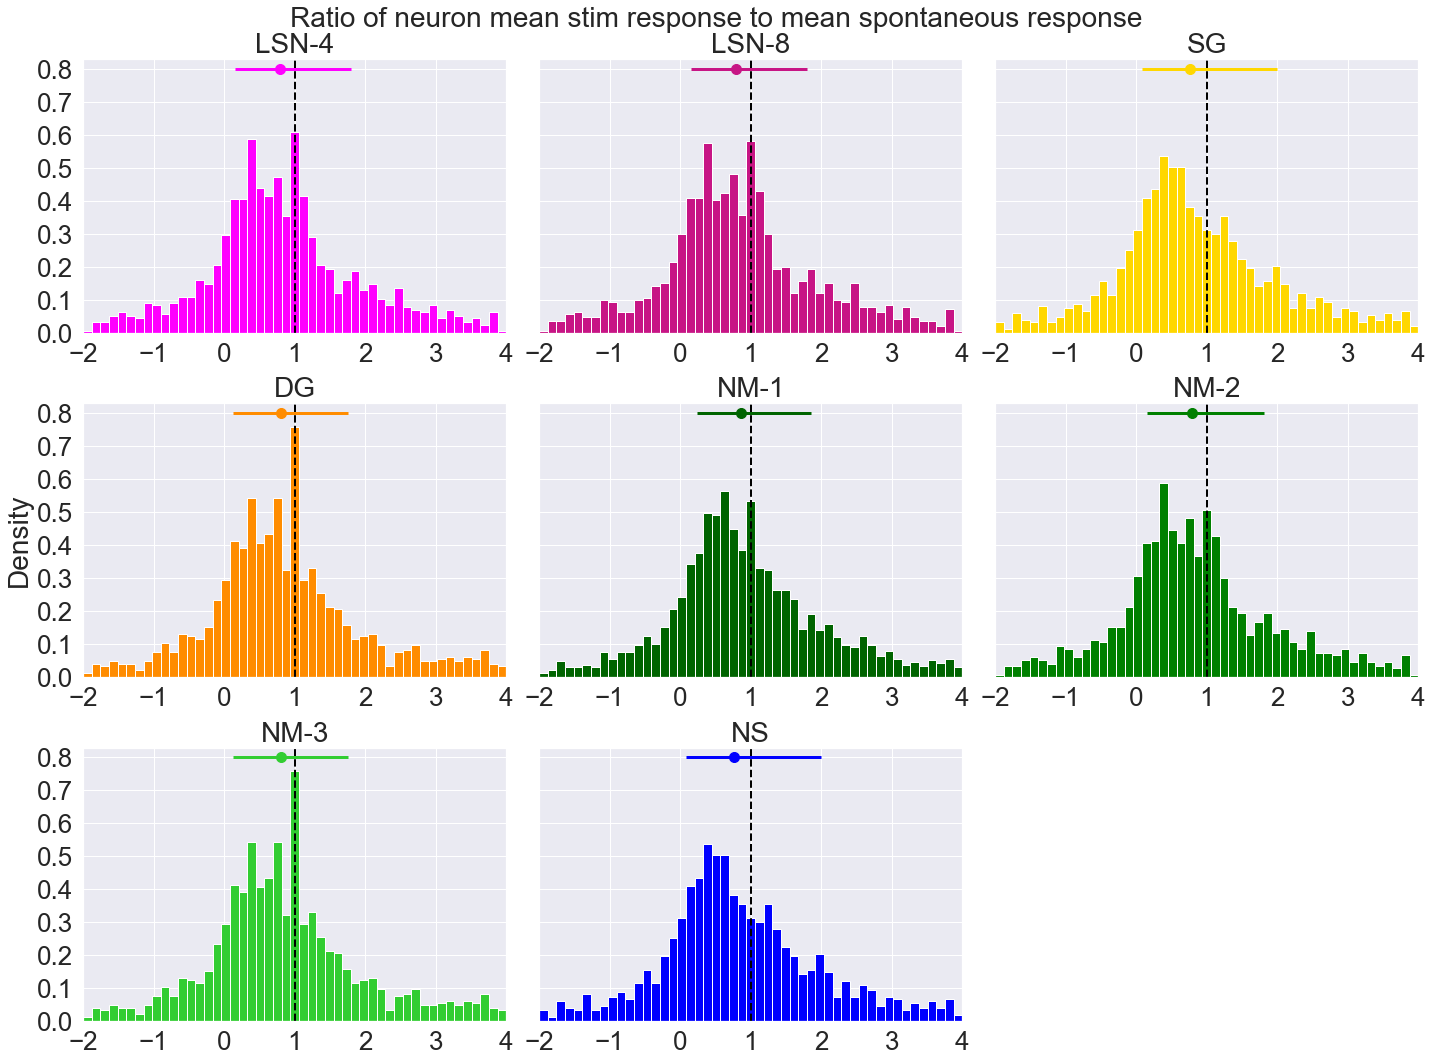

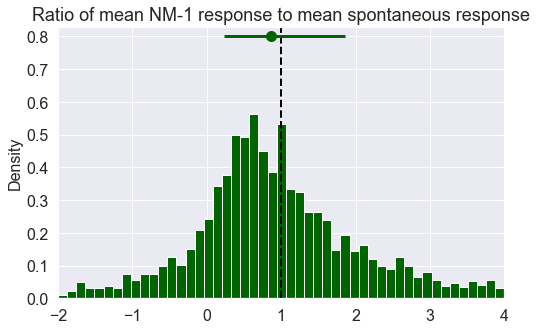

In [16]:
stims = STIM_ORDERING[1:] # Ignore "S"
bins = np.linspace(-2, 4, 50)
fig = plt.figure(figsize=(20, 15), facecolor="white")

for i, stim in enumerate(stims):
    ratios = []

    for r in cell_responses:
        # Ignore cells that don't have enough responses
        # n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
        # if min(n_spontaneous_responses) < SPONT_THRESH:
        #     continue

        # if r["response_classification"] != 1:
        #     continue

        spont_responses, stim_responses = [], []

        for data in r["session_responses"]:
            for stim_full, stim_responses in data.items():
                if STIM_ABBREV[stim_full] == stim:
                    if "spontaneous" in data and len(data["spontaneous"]) >= SPONT_THRESH and len(stim_responses) >= STIM_THRESH:
                        spont_responses.extend(data["spontaneous"])
                        stim_responses.extend(stim_responses)
        
        if len(spont_responses) > 0 and len(stim_responses) > 0:
            mean_spont = np.mean(spont_responses)
            mean_stim = np.mean(stim_responses)
            ratios.append(mean_stim / mean_spont)
            # ratios.append((mean_spont - mean_stim) / (mean_spont + mean_stim))

        # for data in r["session_responses"]:
        #     for stim_full, stim_responses in data.items():
        #         if STIM_ABBREV[stim_full] == stim:
        #             if "spontaneous" in data and len(data["spontaneous"]) >= SPONT_THRESH and len(stim_responses) >= STIM_THRESH:
        #                 spont_resp.append(np.mean(data["spontaneous"]))
        #                 stim_resp.append(np.mean(stim_responses))
        #                 break

    # with plt.style.context("seaborn-whitegrid"):
    ax = fig.add_subplot(3, 3, i+1)
    color = STIM_COLORS[stim]
    ratios = np.array(ratios)
    p25, p50, p75 = np.quantile(ratios, [0.25, 0.5, 0.75])

    # Messy way of also plotting separate figure of NM-1
    axs = [ax]
    if stim == "NM-1":
        f, a = plt.subplots(figsize=(8, 5), facecolor="white")
        axs.append(a)

    for a, ax in enumerate(axs):
        ax.hist(ratios, bins=bins, density=True, color=color)

        # y = ax.get_ylim()[1]
        y = 0.8

        ax.scatter(p50, y, color=color, s=100, zorder=10)
        ax.hlines(xmin=p25, xmax=p75, y=y, color=color, linewidth=3, zorder=10)
        
        print(f"{stim} median = {p50:.2f}, mean = {np.mean(ratios[(bins.min() <= ratios) & (ratios <= bins.max())]):.2f}")

        if i == 3 or a > 0:
            ax.set_ylabel("Density", fontsize=(28 if a == 0 else 16))

        if a == 0 and i % 3 > 0:
            ax.set_yticklabels([])
        
        plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=(26 if a == 0 else 16))

        ax.axvline(1, color="black", linestyle="dashed", lw=2)
        if a == 0:
            ax.set_title(stim, fontsize=28)
        else:
            ax.set_title(f"Ratio of mean {stim} response to mean spontaneous response", fontsize=18)
        ax.set_xlim(bins.min(), bins.max())
        ax.set_ylim(0, 0.83)
        # ax.set_ylim(0, y*1.05)
    
    if len(axs) == 2:
        savefig(axs[1].get_figure(), "nm1_response_ratio_to_spontaneous.png")

fig.suptitle("Ratio of neuron mean stim response to mean spontaneous response", fontsize=28)
fig.tight_layout()
# savefig(fig, "stim_response_ratio_to_spontaneous.png")